# 0.0. Imports

In [1]:
import os
import pickle
import requests
import openpyxl
import warnings
import numpy         as np
import pandas        as pd
import seaborn       as sns
import xgboost       as xgb
import scikitplot    as skplt

from IPython.display         import display, HTML
from sklearn.model_selection import train_test_split
from sklearn                 import preprocessing   as pp
from sklearn                 import linear_model    as lm
from sklearn                 import model_selection as ms
from sklearn                 import ensemble        as en
from sklearn                 import neighbors       as nh
from matplotlib              import pyplot          as plt

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)
display (HTML('<style>.container { width:100% !important; }</style>'))

## 0.1. Loading Dataset

In [3]:
df_raw = pd.read_csv('..\\data\\raw\\train.csv')

In [5]:
X = df_raw.drop(columns='Response')
y = df_raw['Response'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

# 1.0. Data Description

In [6]:
df1 = df_train.copy()

In [7]:
cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 
            'vehicle_age', 'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage', 'response']
df1.columns = cols_new

## 1.1. Data Dimension

In [8]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 304887
Number of columns: 12


## 1.2. Data Types

In [9]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.3. Check NA

In [28]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.4. Data Descriptive

In [29]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [30]:
#central tendency - média e mediana
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std) ).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'media', 'mediana', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,media,mediana,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190594.098072,190639.0,110021.963852,-0.000004,-1.199753
1,age,20.0,85.0,65.0,38.835582,36.0,15.509496,0.670000,-0.570016
2,driving_license,0.0,1.0,1.0,0.997829,1.0,0.046547,-21.390677,455.564047
3,region_code,0.0,52.0,52.0,26.413340,28.0,13.217997,-0.117479,-0.863585
4,previously_insured,0.0,1.0,1.0,0.458373,0.0,0.498264,0.167088,-1.972094
5,annual_premium,2630.0,540165.0,537535.0,30571.851319,31675.0,17254.215590,1.853769,36.695689
6,policy_sales_channel,1.0,163.0,162.0,111.966591,131.0,54.229980,-0.897379,-0.976093
7,vintage,10.0,299.0,289.0,154.272609,154.0,83.642252,0.004656,-1.199888
8,response,0.0,1.0,1.0,0.121970,0.0,0.327251,2.310350,3.337740


# 2.0. Feature Engineering

In [12]:
df2 = df1.copy()

In [13]:
#vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_years'
                                                                       if x == '1-2 Year' else 'below_1_year')

#vehicle damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

# 3.0. Data Filtering

In [14]:
df3 = df2.copy()

# 4.0. Exploratoria Data Analysis

In [15]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Age

<Axes: xlabel='response', ylabel='age'>

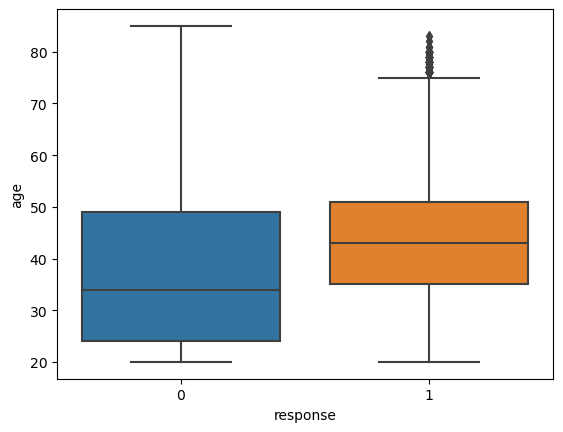

In [16]:
sns.boxplot(x='response', y='age', data=df4)

<Axes: xlabel='age', ylabel='Count'>

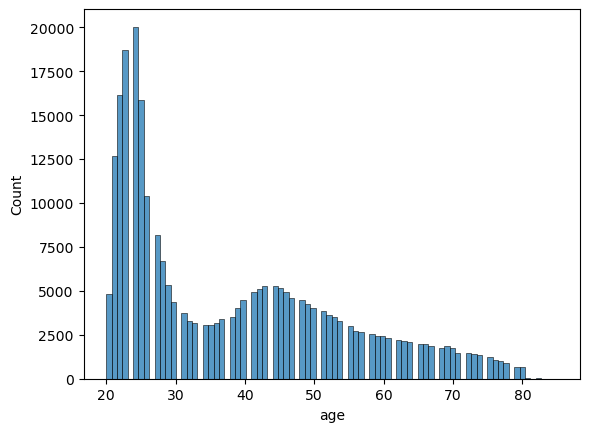

In [17]:
#Clientes SEM interesse

aux00 = df4.loc[df4['response'] == 0, 'age']
sns.histplot(aux00)

<Axes: xlabel='age', ylabel='Count'>

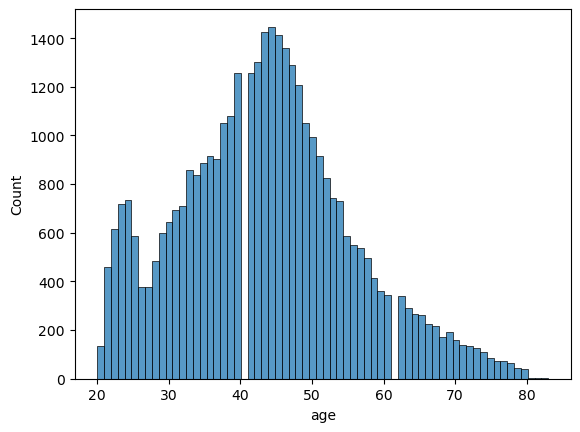

In [18]:
##Clientes COM interesse

aux00 = df4.loc[df4['response'] == 1, 'age']
sns.histplot(aux00)

- Boxplot apontou uma mediana próxima dos 34 anos para os clientes que responderam positivamente a pesquisa, enquanto para os demais a mediana marcou próximo de 35 anos
- Histograma destacou uma grande concentração dos dados próximo aos 45 anos para os clientes que responderam positivamente a pesquisa enquanto, tendo uma maior concentração sos 25 anos par os demais casos

### 4.1.2. annual_premium

<Axes: xlabel='response', ylabel='annual_premium'>

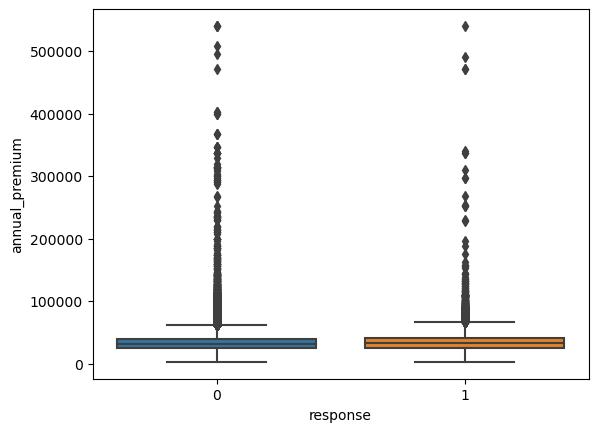

In [38]:
sns.boxplot(x='response', y='annual_premium', data=df4)

<Axes: xlabel='response', ylabel='annual_premium'>

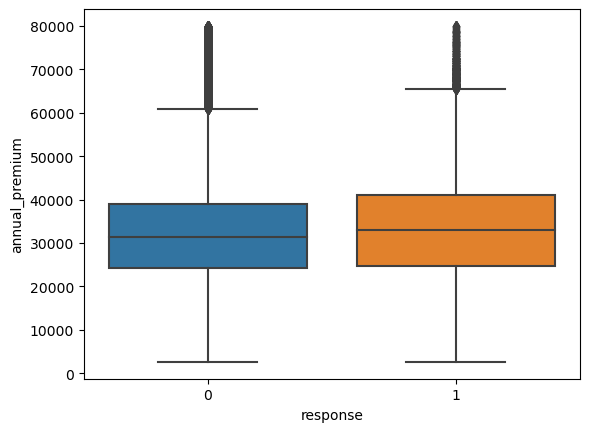

In [39]:
#-> com filtro para conseguir analisar

aux = df4[df4['annual_premium'] < 80000]
sns.boxplot(x='response', y='annual_premium', data=aux)

<Axes: xlabel='annual_premium', ylabel='Count'>

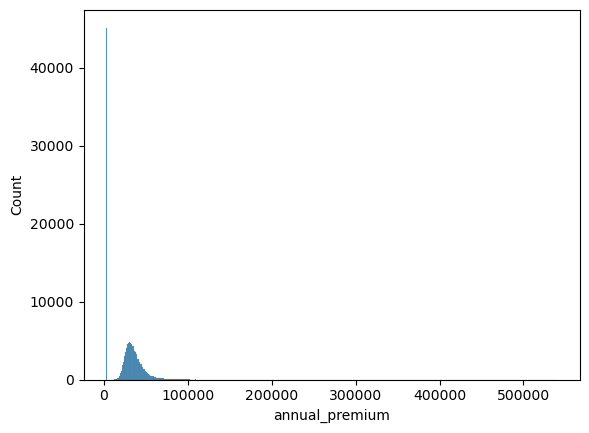

In [40]:
#Clientes SEM interesse

aux = df4.loc[df4['response'] == 0, 'annual_premium']
sns.histplot(aux)

<Axes: xlabel='annual_premium', ylabel='Count'>

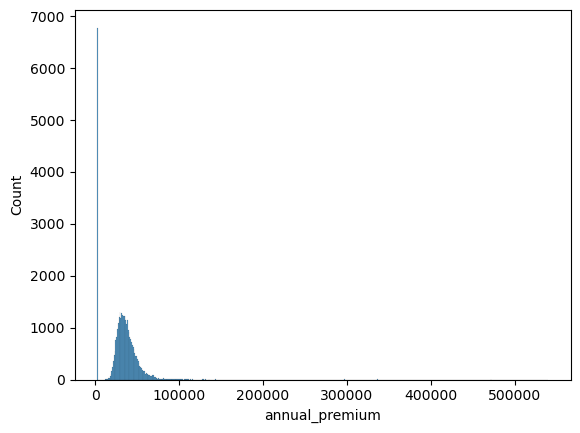

In [41]:
#Clientes COM interesse

aux = df4.loc[df4['response'] == 1, 'annual_premium']
sns.histplot(aux)

In [42]:
df4['annual_premium'].min()

2630.0

<Axes: xlabel='annual_premium', ylabel='Count'>

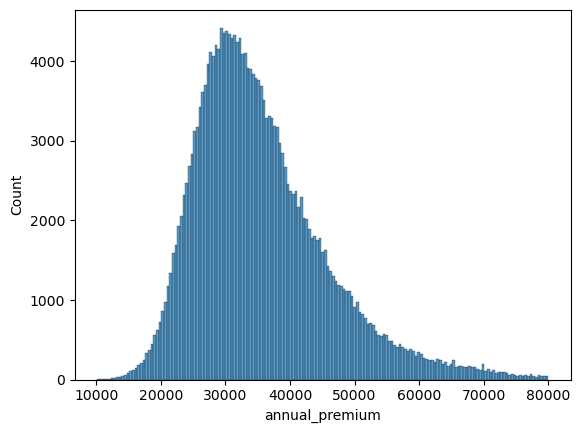

In [43]:
#Clientes SEM interesse
#-> com filtro para conseguir analisar

aux = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]
aux = aux.loc[aux['response'] == 0, 'annual_premium']
sns.histplot(aux)

<Axes: xlabel='annual_premium', ylabel='Count'>

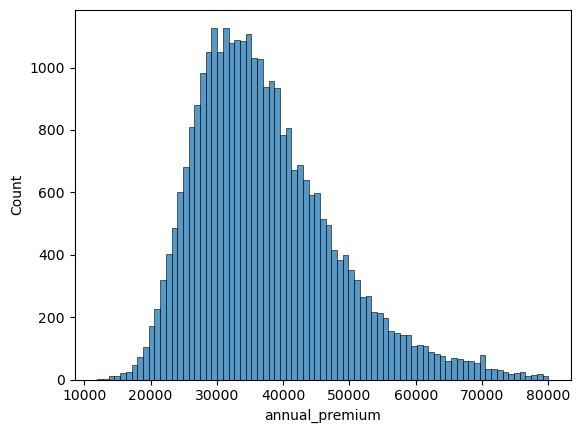

In [44]:
#Clientes COM interesse
#-> com filtro para conseguir analisar

aux = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]
aux = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot(aux)

In [45]:
df4.value_counts('response', normalize=True)

response
0    0.87803
1    0.12197
Name: proportion, dtype: float64

In [46]:
aux = df4[df4['annual_premium'] > 80000]
aux['response'].value_counts(normalize=True)

response
0    0.849037
1    0.150963
Name: proportion, dtype: float64

- Boxplot identificou uma grande quantidade de outliers, tanto para quem respondeu sim à pesquisa como para quem respondeu não. Tendo o 4º quartil ficado abaixo de 100000, e os outliers variando até 500000. A mediana de ambos os casos ficou próximo de 30000
- Com base nos histogramas identificamos uma semelhança muito grande entre ambos os casos, e se destacou também uma alta concentração em apenas um valor 2630. O que deve se tratar de um valor mínimo. 
- Ao aplicar um filtro para remover os outliers ficou claro de que em ambos os casos se trata de uma destribuição muito próxima de uma normal.
- Observando apenas dos outliers, percebemos que esses valores discrepantes seguem contendo a mesma proporção de casos positivos e negativos

### 4.1.3. driving_license

In [57]:
aux_0 = df4[df4['driving_license'] == 0]
value_counts_0 = aux_0['response'].value_counts(normalize=True).reset_index() * 100
value_counts_0['proportion'] = value_counts_0['proportion']

aux_1 = df4[df4['driving_license'] == 1]
value_counts_1 = aux_1['response'].value_counts(normalize=True).reset_index() * 100
value_counts_1['proportion'] = value_counts_1['proportion']

response_counts = df4['response'].value_counts(normalize=True).reset_index() * 100
response_counts['proportion'] = value_counts_1['proportion']

value_counts_0 =value_counts_0.rename(columns={'proportion': 'driving_license_0_perc'})
value_counts_1 = value_counts_1.rename(columns={'proportion': 'driving_license_1_perc'})
value_counts_1 = value_counts_1.drop(columns='response')
response_counts = response_counts.rename(columns={'proportion': 'raw_proportion'})
response_counts = response_counts.drop(columns='response')

result = pd.concat([value_counts_0, value_counts_1, response_counts], axis=1)
result

,response,driving_license_0_perc,driving_license_1_perc,raw_proportion
0,0,95.015106,87.787328,87.787328
1,100,4.984894,12.212672,12.212672


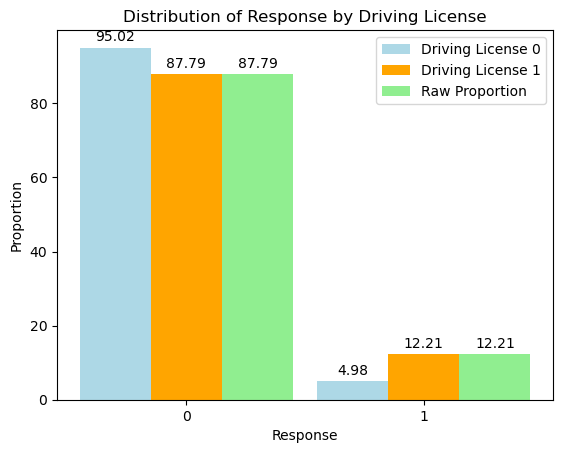

In [58]:
bar_width = 0.3
index = np.arange(2)

fig, ax = plt.subplots()

bar1 = ax.bar(index, result['driving_license_0_perc'], bar_width, label='Driving License 0', color='lightblue')
bar2 = ax.bar(index + bar_width, result['driving_license_1_perc'], bar_width, label='Driving License 1', color='orange')
bar3 = ax.bar(index + 2 * bar_width, result['raw_proportion'], bar_width, label='Raw Proportion', color='lightgreen')

# Adiciona rótulos nas barras
for bars in [bar1, bar2, bar3]:
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 1, round(yval, 2), ha='center', va='bottom')

# Adiciona rótulos, título e legenda
ax.set_xlabel('Response')
ax.set_ylabel('Proportion')
ax.set_title('Distribution of Response by Driving License')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(['0', '1'])
ax.legend()

# Exibe o gráfico
plt.show()

- Conseguimos identificar que quando o cliente não possui CNH (driving license) a quantidade de respostas positivas (clientes com interesse) reduz aproximadamente pela metade

### 4.1.4. region_code

<Axes: xlabel='region_code', ylabel='id'>

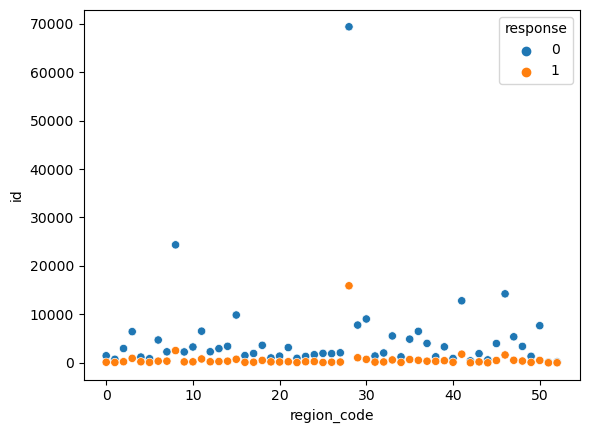

In [59]:
aux0 = df4[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()
sns.scatterplot(x='region_code', y='id', hue='response', data=aux0)

In [60]:
aux = aux0[aux0['id'] > 50000]
max_region_code = aux['region_code'].max()
aux0[aux0['region_code'] == max_region_code]

,region_code,response,id
56,28.0,0,69349
57,28.0,1,15907


- Identificamos que o ponto que se destaca no scatterplot referente a quantidade de respostas positivas e negativas para cada região, é referente a regiao 28. E foi confirmado que a região com maior quantidade de clientes com interesse é a mesma dos clientes sem interesse (região de código 28)

### 4.1.5. previously_insured

In [61]:
table = pd.crosstab(df4['response'], df4['previously_insured'], normalize='columns') * 100
table.columns = ['Não', 'Sim']
table['total_response'] = df4['response'].value_counts(normalize=True) * 100
table

,Não,Sim,total_response
response,,,
0,77.554728,99.912703,87.803022
1,22.445272,0.087297,12.196978


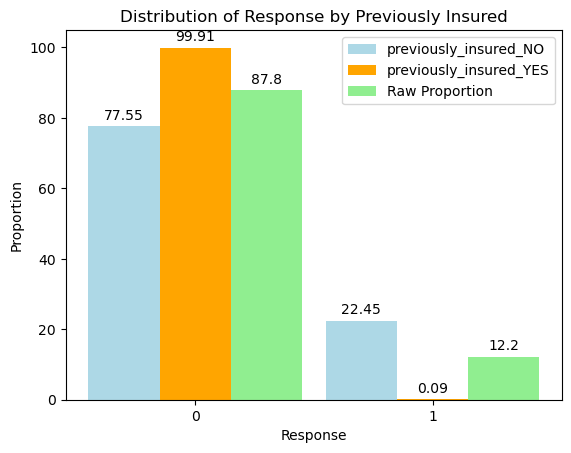

In [62]:
bar_width = 0.3
index = np.arange(2)

fig, ax = plt.subplots()

bar1 = ax.bar(index, table['Não'], bar_width, label='previously_insured_NO', color='lightblue')
bar2 = ax.bar(index + bar_width, table['Sim'], bar_width, label='previously_insured_YES', color='orange')
bar3 = ax.bar(index + 2 * bar_width, table['total_response'], bar_width, label='Raw Proportion', color='lightgreen')

# Adiciona rótulos nas barras
for bars in [bar1, bar2, bar3]:
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 1, round(yval, 2), ha='center', va='bottom')

# Adiciona rótulos, título e legenda
ax.set_xlabel('Response')
ax.set_ylabel('Proportion')
ax.set_title('Distribution of Response by Previously Insured')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(['0', '1'])
ax.legend()

# Exibe o gráfico
plt.show()

- Identificamos um contraste muito grande quando comparado a proporção de clientes interessados e não interessados quando analisamos 3 cenários diferentes, sendo eles:
1. Azul - Clientes que que **NÃO** tiveram seguro anteriormente
2. Laranja - Clientes que que tiveram seguro anteriormente
3. Verde - Todos os clientes (padrão)

- Os clientes que **NÃO** tiveram seguro anteriormente se mostraram menos interessados em contratar um novo serviço. Apenas 0,09%, muito inferior aos 12% do total da pesquisa.
- Os clientes que tiveram seguro anteriormente se mostraram mais interessados em contratar um novo serviço, sendo eles 22,55% quase o dobro da parcela total da pesquisa.

### 4.1.6. vehicle_age

In [63]:
table = pd.crosstab(df4['response'], df4['vehicle_age'], normalize='columns') * 100
table.columns = ['below_1_year', 'between_1_2_years', 'over_2_years']
table['total_response'] = df4['response'].value_counts(normalize=True) * 100
table

,below_1_year,between_1_2_years,over_2_years,total_response
response,,,,
0,95.640286,82.741484,70.678388,87.803022
1,4.359714,17.258516,29.321612,12.196978


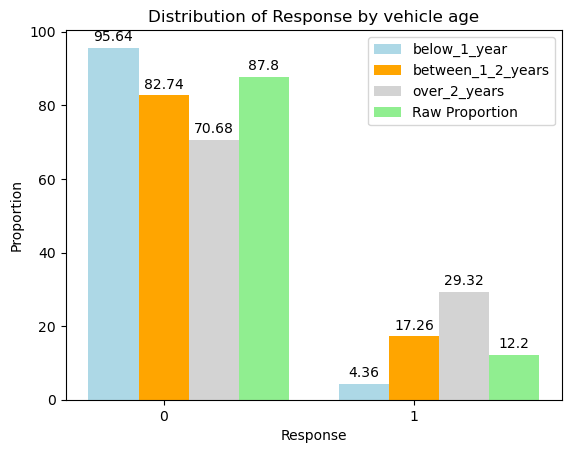

In [64]:
bar_width = 0.2
index = np.arange(2)

fig, ax = plt.subplots()

bar1 = ax.bar(index, table['below_1_year'], bar_width, label='below_1_year', color='lightblue')
bar2 = ax.bar(index + bar_width, table['between_1_2_years'], bar_width, label='between_1_2_years', color='orange')
bar3 = ax.bar(index + 2 * bar_width, table['over_2_years'], bar_width, label='over_2_years', color='lightgrey')
bar4 = ax.bar(index + 3 * bar_width, table['total_response'], bar_width, label='Raw Proportion', color='lightgreen')

# Adiciona rótulos nas barras
for bars in [bar1, bar2, bar3, bar4]:
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 1, round(yval, 2), ha='center', va='bottom')

# Adiciona rótulos, título e legenda
ax.set_xlabel('Response')
ax.set_ylabel('Proportion')
ax.set_title('Distribution of Response by vehicle age')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(['0', '1'])
ax.legend()

# Exibe o gráfico
plt.show()

- Já para a idade do veículo identificamos que quanto mais antigo o veículo, maior é a parcela dos clientes querendo contratar o novo serviço

### 4.1.7. policy_sales_channel

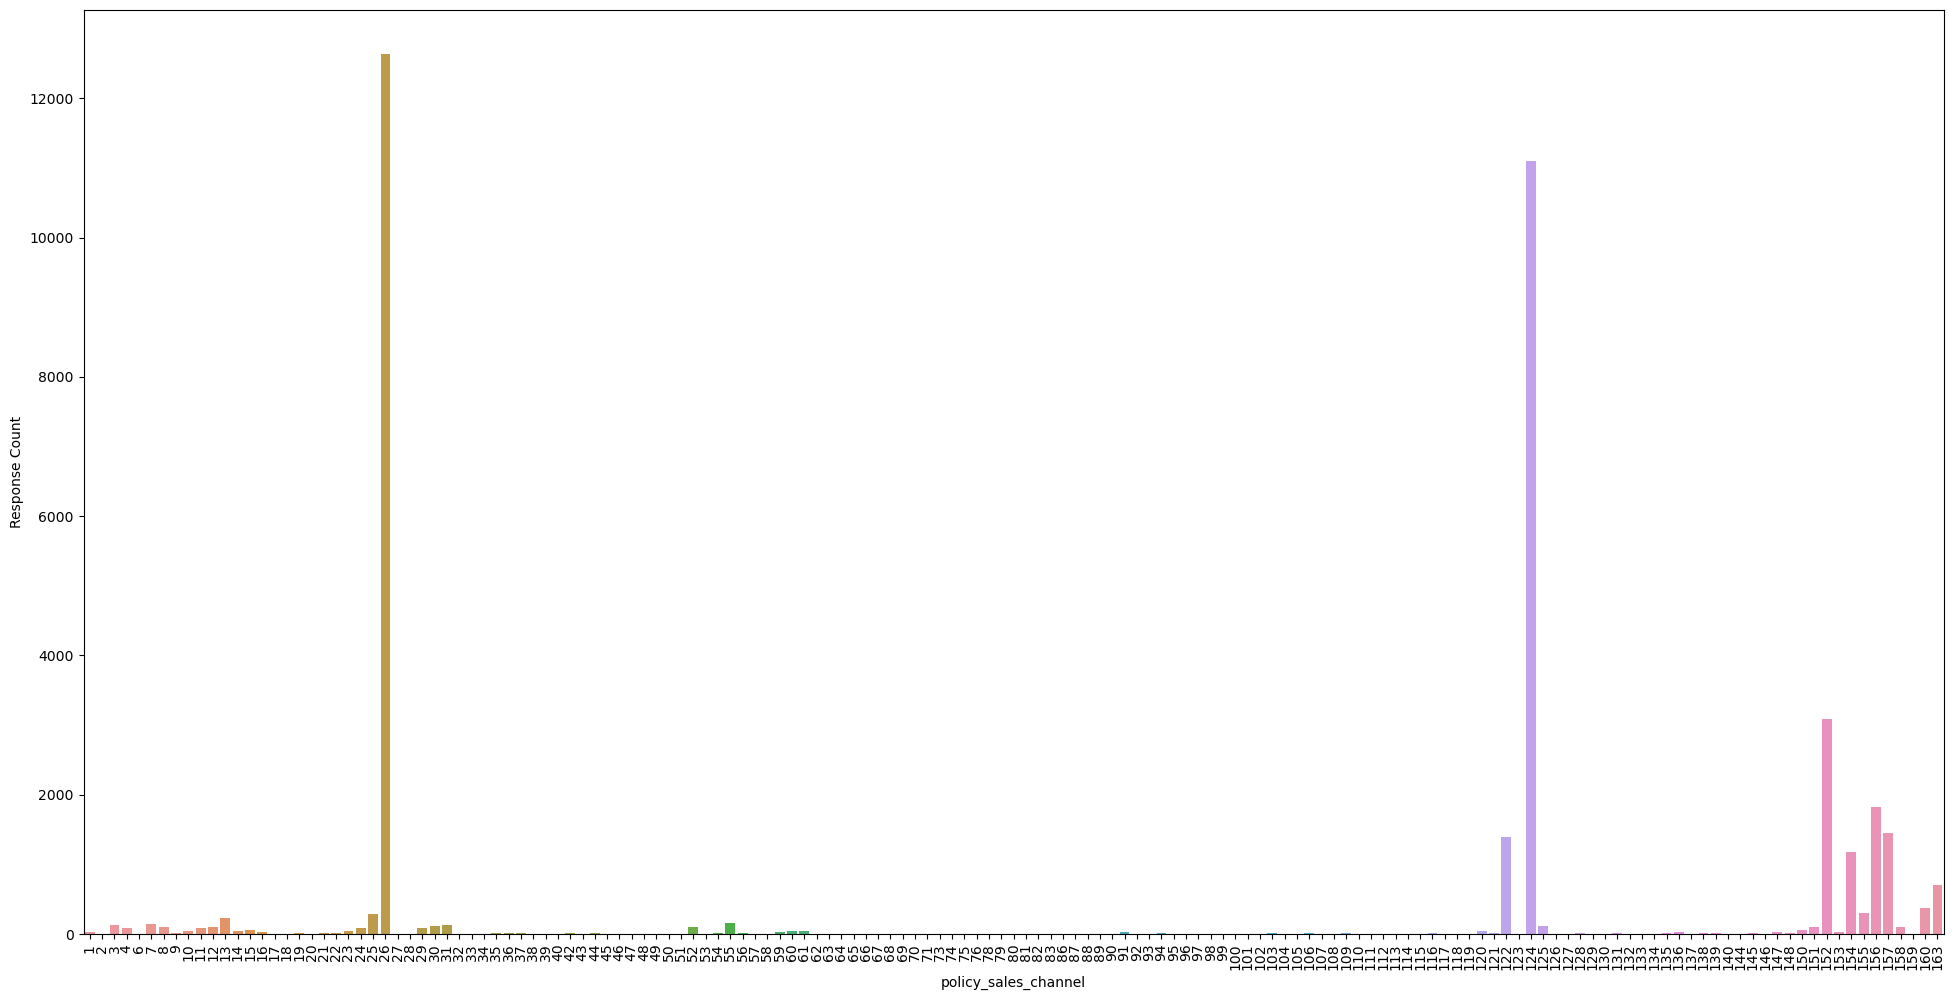

In [65]:
plt.figure(figsize=(24, 12))
aux = df4[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()
aux['policy_sales_channel'] = aux['policy_sales_channel'].astype(int)
ax = sns.barplot(x='policy_sales_channel', y='response', data=aux)
ax.set(ylabel='Response Count')  
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)  
plt.show()

- Quanto ao policy_sales_channel, identificamos 2 casos que se destacaram, foram os de número 26 e 124

### 4.1.8. vintage

<Axes: xlabel='response', ylabel='vintage'>

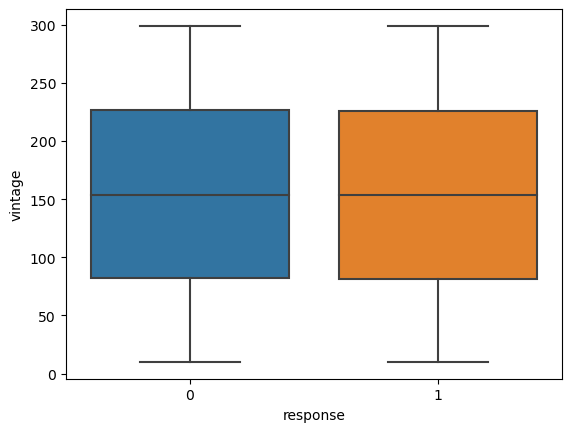

In [66]:
sns.boxplot(x='response', y='vintage', data=df4)

<Axes: xlabel='vintage', ylabel='Count'>

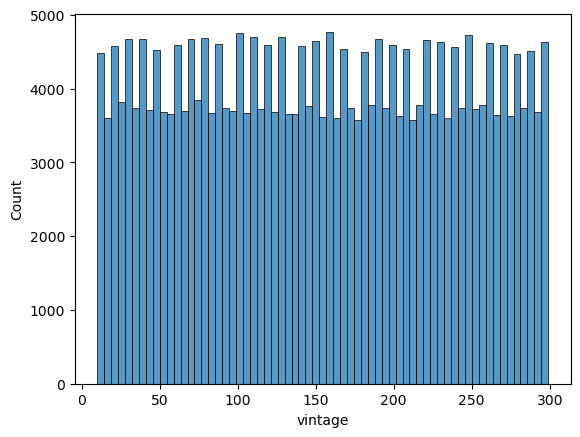

In [67]:
#Clientes SEM interesse

aux00 = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot(aux00)

<Axes: xlabel='vintage', ylabel='Count'>

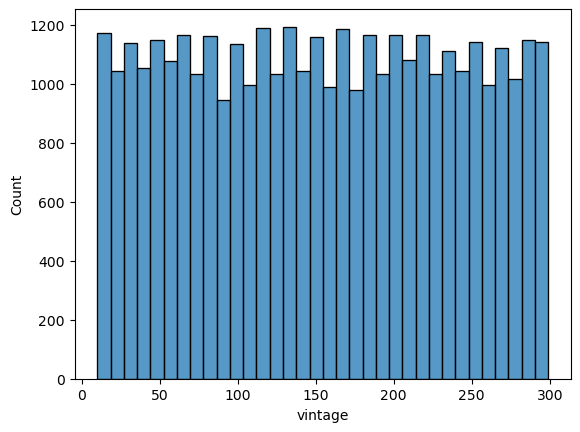

In [68]:
#Clientes COM interesse

aux00 = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot(aux00)

- Quanto a feature Vintage, não foi idetificada nenhuma variação entre as parcelas de clientes interessados e não interessados, mantendo quase igual nos 2 casos

## 4.2. Multivariate Analysis

In [69]:
num_attributes2 = df4.select_dtypes(include=['int64', 'float64'])
cat_attributes2 = df4.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

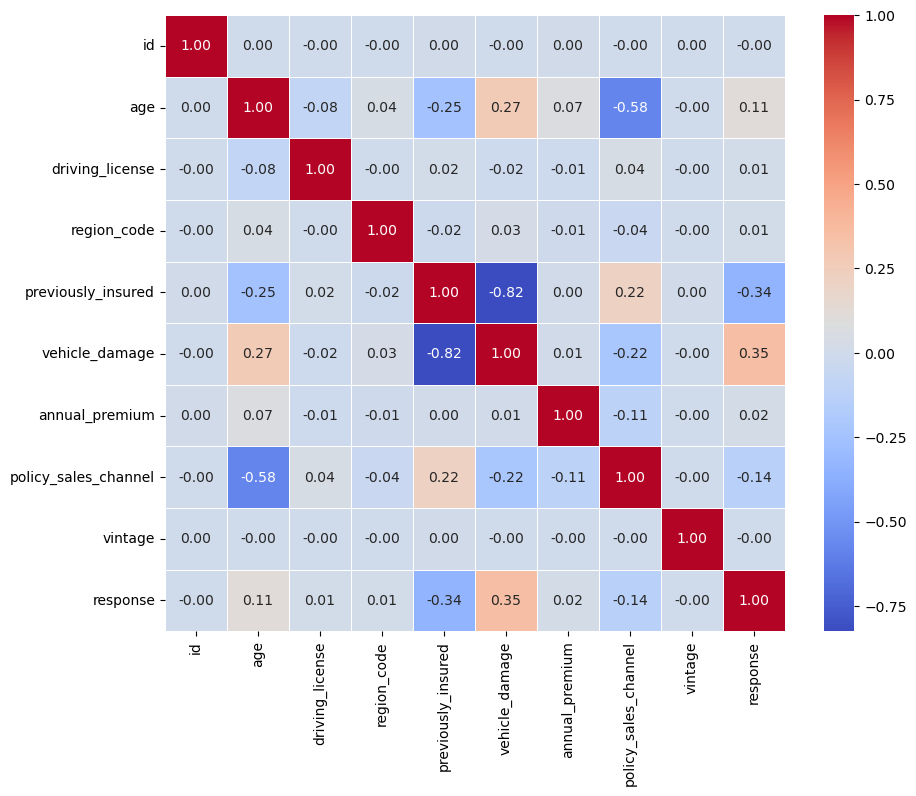

In [70]:
correlation_matrix = num_attributes2.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.show()

#### PRINCIPAIS OBSERVAÇOES
- **Veículo Danificado (Vehicle Damage)** 
    - Correlação positiva significativa com o interesse no novo seguro. Clientes com veículos danificados têm maior probabilidade de expressar interesse.
- **Seguro Anterior (Previously Insured)** 
    - Correlação negativa notável. Clientes que já possuíam seguro anteriormente têm menor propensão a manifestar interesse no novo seguro residencial.
- **Idade (Age)** 
    - Correlação positiva leve. Indica que clientes ligeiramente mais jovens podem ter uma tendência sutilmente maior de demonstrar interesse.


# 5.0. Data Preparation

In [19]:
df5 = df4.copy()

## 5.1. Standardization

In [20]:
ss = pp.StandardScaler()

# annual_premium
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)
pickle.dump( ss, open( '../src/features/annual_premium_scaler.pkl', 'wb' ) )

## 5.2. Rescaling

In [21]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# age
df5['age'] = mms_age.fit_transform(df5[['age']].values)
pickle.dump( mms_age, open( '../src/features/age_scaler.pkl', 'wb' ) )

# vintage
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)
pickle.dump( mms_vintage, open( '../src/features/vintage_scaler.pkl', 'wb' ) )

## 5.3. Encoder

In [22]:
# gender - One Hot Encoding / Target Encoding
target_encode_gender = df5.groupby( 'gender' )['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )
pickle.dump( target_encode_gender, open( '../src/features/target_encode_gender_scaler.pkl', 'wb' ) )

# region_code - Target Encoding / Frequency Encoding
target_encode_region_code = df5.groupby( 'region_code' )['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code )
pickle.dump( target_encode_region_code, open( '../src/features/target_encode_region_code_scaler.pkl', 'wb' ) )

# vehicle_age - One Hot Encoding / Frequency Encoding
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

# policy_sales_channel - Target Encoding / Frequency Encoding
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len( df5 ) 
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )
pickle.dump( fe_policy_sales_channel, open( '../src/features/fe_policy_sales_channel_scaler.pkl', 'wb' ) )

# 6.0. Feature Selection

In [23]:
df6 = df5.copy()

## 6.1. Features Importance

In [ ]:
# model definition
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# data preparation
x_train_n = df5.drop( ['id', 'response'], axis=1 )
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n )

Feature ranking:
                         feature  importance
0                        vintage    0.273060
0                 annual_premium    0.245104
0                            age    0.164858
0                    region_code    0.106965
0                 vehicle_damage    0.066324
0           policy_sales_channel    0.059156
0             previously_insured    0.057517
0       vehicle_age_below_1_year    0.013606
0  vehicle_age_between_1_2_years    0.006103
0                         gender    0.004627
0       vehicle_age_over_2_years    0.002176
0                driving_license    0.000503


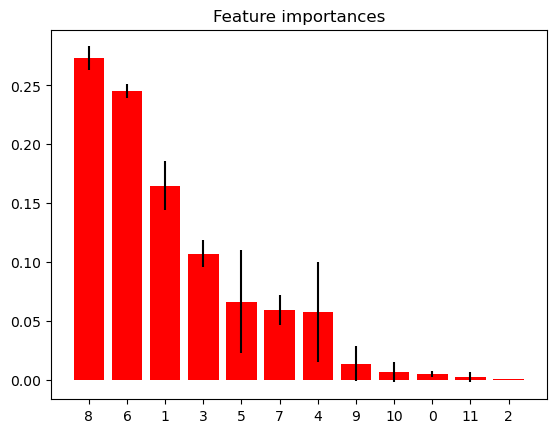

In [76]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

In [ ]:
# Selected Columns
# ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured', 'policy_sales_channel']

# 7.0. Machine Learning

In [25]:
df7 = df6.copy()

In [26]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured', 'policy_sales_channel']

X = df7[cols_selected]
y = df7['response'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## 7.1. KNN

In [119]:
# model definition
knn_model = nh.KNeighborsClassifier( n_neighbors=7 )

# model training
knn_model.fit( X_train, y_train )

# model prediction
yhat_knn = knn_model.predict_proba( X_test )

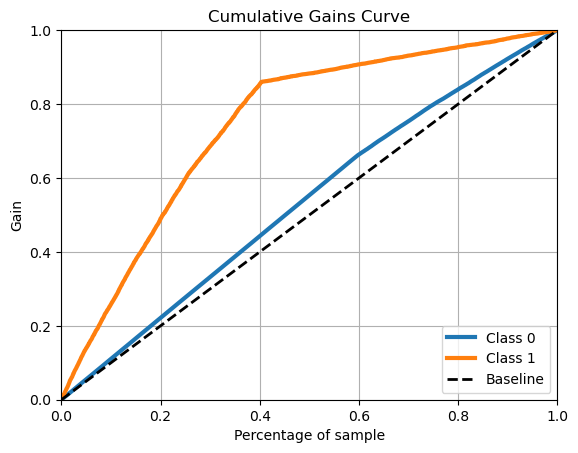

In [120]:
 # Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_test, yhat_knn );

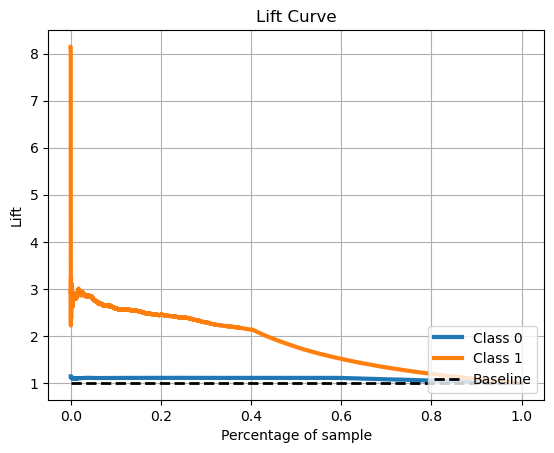

In [122]:
#Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_test, yhat_knn );

## 7.2. Logistic Regression

In [123]:
# model definition
lr_model = lm.LogisticRegression( random_state=42 ) 

# model training
lr_model.fit( X_train, y_train )

# model prediction
yhat_lr = lr_model.predict_proba( X_test )

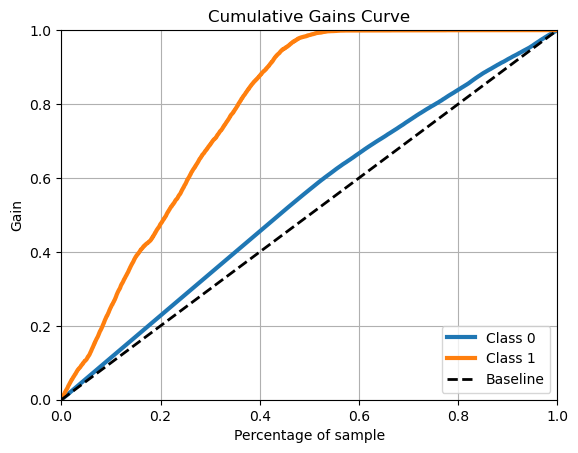

In [124]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_test, yhat_lr );

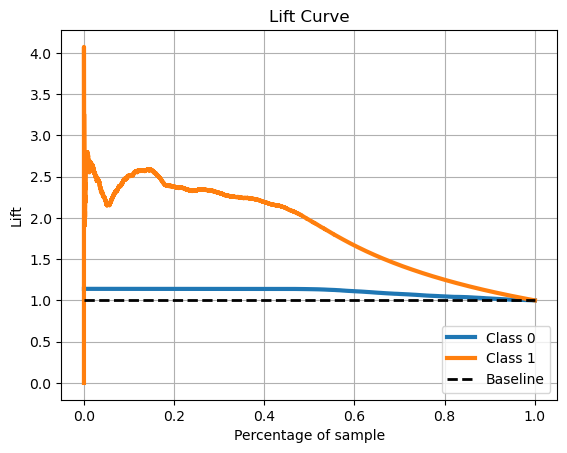

In [126]:
#Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_test, yhat_lr );

## 7.3. Extra Trees Classifier

In [127]:
# model definition
et = en.ExtraTreesClassifier( n_estimators=1000, n_jobs=-1, random_state=42 )

# model fit
et.fit( X_train, y_train )

# model predict
yhat_et = et.predict_proba( X_test )

<Axes: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

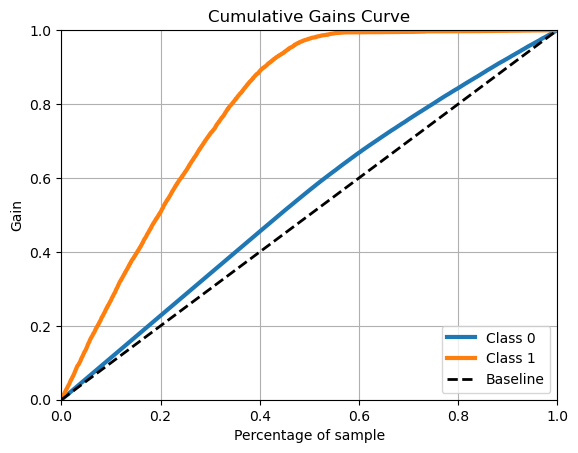

In [128]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_test, yhat_et )

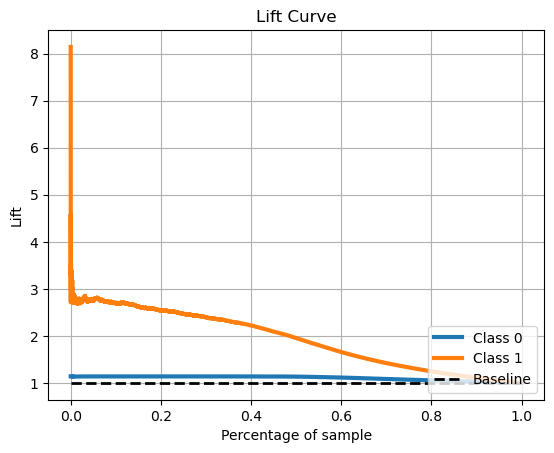

In [129]:
#Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_test, yhat_et );

## 7.4. Random Forest

In [130]:
# model definition
rf = en.RandomForestClassifier( n_estimators=500, n_jobs=-1, random_state=42 ) 

# model training
rf.fit( X_train, y_train )

# model prediction
yhat_rf = rf.predict_proba( X_test )

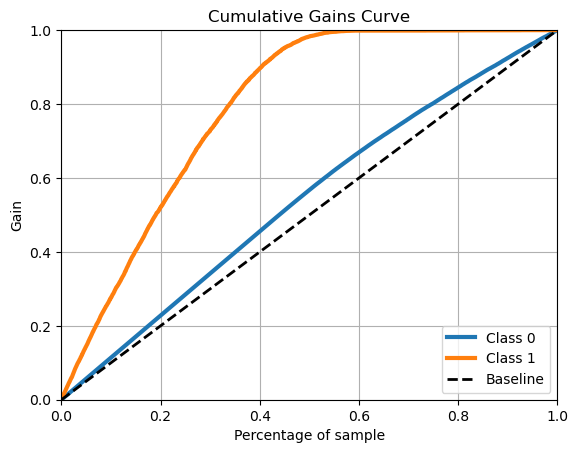

In [131]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_test, yhat_rf );

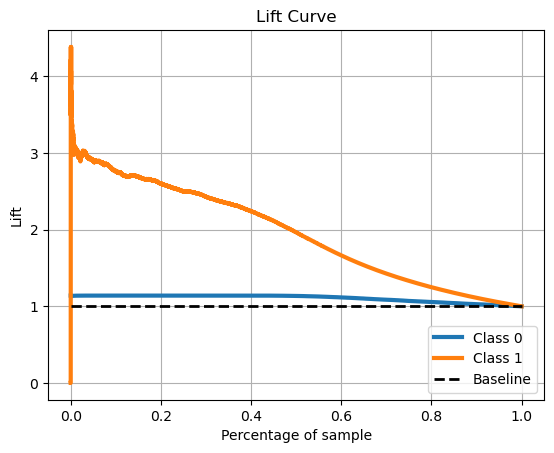

In [132]:
#Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_test, yhat_rf );

## 7.5 XGBoost Classifier

In [146]:
# model definition
xgb = xgb.XGBClassifier()

# model training
xgb.fit(X_train, y_train)

# model prediction
yhat_xgb = xgb.predict_proba(X_test)

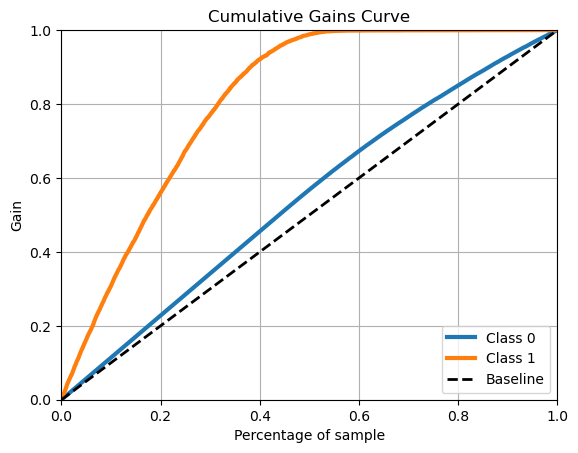

In [147]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_test, yhat_xgb );

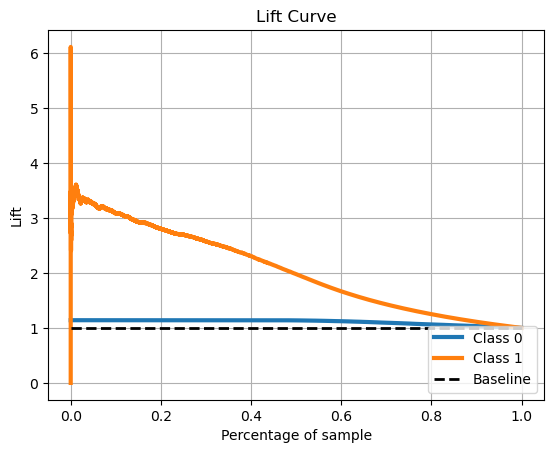

In [148]:
#Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_test, yhat_xgb );

# 8.0. Performance Metrics

## 8.1. Preparing df_test

In [27]:
cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 
            'vehicle_age', 'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage', 'response']
df_test.columns = cols_new

# FEATURE ENGINEERING
#vehicle age
df_test['vehicle_age'] = df_test['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_years'
                                                                       if x == '1-2 Year' else 'below_1_year')

#vehicle damage
df_test['vehicle_damage'] = df_test['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

# DATA PREPARATION
# gender
df_test.loc[:, 'gender'] =  df_test.loc[:, 'gender'].map( target_encode_gender )

# age
df_test.loc[:, 'age'] = mms_age.transform( df_test[['age']].values )

# region_code
df_test.loc[:, 'region_code'] = df_test.loc[:, 'region_code'].map( target_encode_region_code )

# vehicle_age
df_test = pd.get_dummies( df_test, prefix='vehicle_age', columns=['vehicle_age'] )

# annual_premium
df_test.loc[:, 'annual_premium'] = ss.transform( df_test[['annual_premium']].values )

# policy_sales_channel
df_test.loc[:, 'policy_sales_channel'] = df_test['policy_sales_channel'].map( fe_policy_sales_channel )

# vintage
df_test.loc[:, 'vintage'] = mms_vintage.transform( df_test[['vintage']].values )

In [28]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured', 'policy_sales_channel']

X_train = df7[cols_selected]
y_train = df7['response'].copy()

X_test = df_test[cols_selected]
y_test = df_test['response'].copy()

## 8.2. Evaluating Model Performance

In [29]:
# model definition
xgb_model = xgb.XGBClassifier()

# model training
xgb_model.fit(X_train, y_train)

# model prediction
yhat_xgb = xgb_model.predict_proba(X_test)

In [37]:
# Save trained model
pickle.dump( xgb_model, open( '..\\src\\models\\model_health_insurance.pkl', 'wb' ) )

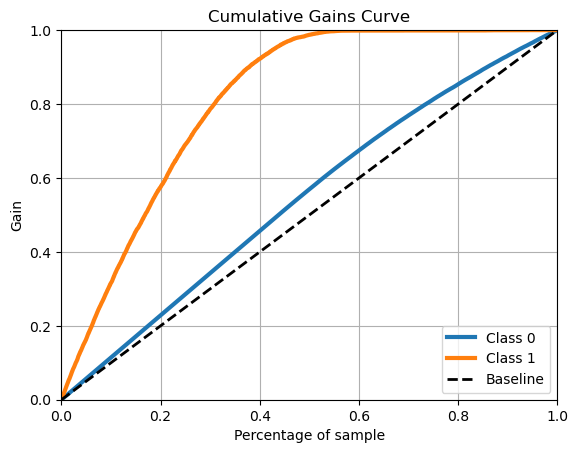

In [30]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_test, yhat_xgb );

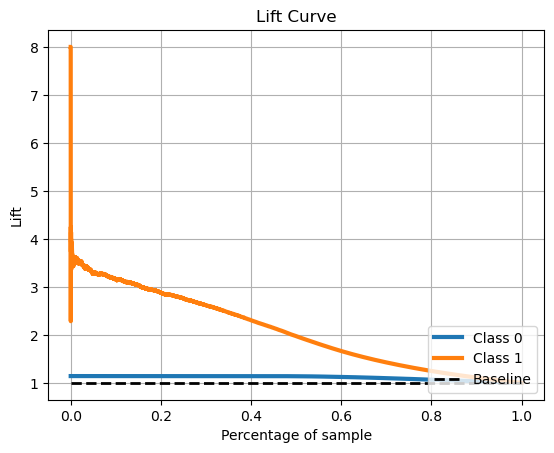

In [31]:
#Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_test, yhat_xgb );

In [32]:
def precision_at_k( data_precision, k=20 ):
    # reset index
    data_precision = data_precision.reset_index( drop=True )

    # create ranking order
    data_precision['ranking'] = data_precision.index + 1 

    data_precision['precision_at_k'] = data_precision['response'].cumsum() / data_precision['ranking']

    return ( data_precision.loc[ k, 'precision_at_k'], data_precision )

def recall_at_k( data_recall, k=15 ):
    # reset index
    data_recall = data_recall.reset_index( drop=True )

    # create ranking order
    data_recall['ranking'] = data_recall.index + 1 

    data_recall['recall_at_k'] = data_recall['response'].cumsum() / data_recall['response'].sum()

    return ( data_recall.loc[ k-1, 'recall_at_k'], data_recall )

In [33]:
# propensity score
df_test['score'] = yhat_xgb[:, 1].tolist()

# sort clients by propensity score
df_test = df_test.sort_values( 'score', ascending=False )


In [34]:
twenty_percent = round(df_test.shape[0] * 0.2)
twenty_percent

15244

In [35]:
# compute precision at k 
precision_at_20, data = precision_at_k( df_test, k=twenty_percent )
precision_at_20

0.3595933092817317

In [36]:
# compute recall at k
recall_at_15, data = recall_at_k( df_test, k=twenty_percent )
recall_at_15

0.5755539220833771

- By targeting **20% of the customers** from the test set, the sales team can achieve a **precision rate of 35.96%** and a **recall rate of 57.56%**.

- This means that, by following the predictions of the XGBoost model, the first 20% of customers encompass 57.56% of all those interested in hiring a new service. 

- This approach **triples** the efficiency of the sales team compared to a random selection, as 35.96% of customers in this model-selected sample express interest, unlike a random sample that would have only 12.19%.

# 9.0. Deploy to Production

## 9.1. Health Insurance Class

In [42]:
import pickle
import numpy  as np
import pandas as pd

class HealthInsurance:
    
    def __init__( self ):
        self.annual_premium_scaler =            pickle.load( open( '\\Users\\galves\\Documents\\Gabriel\\Ciência de dados\\Cursos\\new_project\\health_insurance_app\\features\\annual_premium_scaler.pkl' ) )
        self.age_scaler =                       pickle.load( open( '\\Users\\galves\\Documents\\Gabriel\\Ciência de dados\\Cursos\\new_project\\health_insurance_app\\features\\age_scaler.pkl' ) ) 
        self.vintage_scaler =                   pickle.load( open( '\\Users\\galves\\Documents\\Gabriel\\Ciência de dados\\Cursos\\new_project\\health_insurance_app\\features\\vintage_scaler.pkl' ) ) 
        self.target_encode_gender_scaler =      pickle.load( open( '\\Users\\galves\\Documents\\Gabriel\\Ciência de dados\\Cursos\\new_project\\health_insurance_app\\features\\target_encode_gender_scaler.pkl' ) )
        self.target_encode_region_code_scaler = pickle.load( open( '\\Users\\galves\\Documents\\Gabriel\\Ciência de dados\\Cursos\\new_project\\health_insurance_app\\features\\target_encode_region_code_scaler.pkl' ) )
        self.fe_policy_sales_channel_scaler =   pickle.load( open( '\\Users\\galves\\Documents\\Gabriel\\Ciência de dados\\Cursos\\new_project\\health_insurance_app\\features\\fe_policy_sales_channel_scaler.pkl' ) )
        
    def data_cleaning( self, df1 ):
        # 1.1. Rename Columns
        cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 
                    'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage', 'response']

        # rename 
        df1.columns = cols_new
        
        return df1 

    
    def feature_engineering( self, df2 ):
        # 2.0. Feature Engineering

        # Vehicle Damage Number
        df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

        # Vehicle Age
        df2['vehicle_age'] =  df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' )
        
        return df2
    
    
    def data_preparation( self, df5 ):
        # anual premium - StandarScaler
        df5['annual_premium'] = self.annual_premium_scaler.transform( df5[['annual_premium']].values )

        # Age - MinMaxScaler
        df5['age'] = self.age_scaler.transform( df5[['age']].values )

        # Vintage - MinMaxScaler
        df5['vintage'] = self.vintage_scaler.transform( df5[['vintage']].values )

        # gender - One Hot Encoding / Target Encoding
        df5.loc[:, 'gender'] = df5['gender'].map( self.target_encode_gender )

        # region_code - Target Encoding / Frequency Encoding
        df5.loc[:, 'region_code'] = df5['region_code'].map( self.target_encode_region_code )

        # vehicle_age - One Hot Encoding / Frequency Encoding
        df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

        # policy_sales_channel - Target Encoding / Frequency Encoding
        df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( self.fe_policy_sales_channel )
        
        # Feature Selection
        cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                         'policy_sales_channel']
        
        return df5[ cols_selected ]
    
    
    def get_prediction( self, model, original_data, test_data ):
        # model prediction
        pred = model.predict_proba( test_data )
        
        # join prediction into original data
        original_data['score'] = pred
        
        return original_data.to_json( orient='records', date_format='iso' )

## 9.2. API Handler

In [ ]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from healthinsurance import HealthInsurance

# loading model
model = pickle.load( open( '\\Users\\galves\\Documents\\Gabriel\\Ciência de dados\\Cursos\\new_project\\health_insurance_app\\models\\model_health_insurance.pkl', 'rb' ) )

# initialize API
app = Flask( __name__ )

@app.route( '/predict', methods=['POST'] )
def health_insurance_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate HealthInsurance class
        pipeline = HealthInsurance()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
    
    else:
        return Response( '{}', status=200, mimetype='application/json' )
    
if __name__ == '__main__':
    app.run( '0.0.0.0', debug=True )

## 9.3. API Tester

### 9.3.1. Loading df_test

In [4]:
X = df_raw.drop(columns='Response')
y = df_raw['Response'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

In [13]:
df_test.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [6]:
df_test.to_excel('..//df_test.xlsx')

In [8]:
import json

# convert dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

### 9.3.2. Testing local API

In [10]:
# API Call (local)
url = 'http://192.168.0.90:5000/predict'
header = {'Content-type': 'application/json' }

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [11]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )
d1.sort_values( 'score', ascending=False ).head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,score
36893,225403,0.137774,0.307692,1,0.186579,0,between_1_2_year,1,0.495308,53.0,0.307958,1,0.729799
25712,233271,0.137774,0.200000,1,0.061820,0,below_1_year,1,-0.050240,124.0,0.010381,1,0.688505
43790,261640,0.137774,0.384615,1,0.067393,0,between_1_2_year,1,0.219201,116.0,0.474048,0,0.687310
9430,366785,0.137774,0.400000,1,0.186579,0,between_1_2_year,1,1.543052,53.0,0.816609,0,0.675305
64536,321615,0.103373,0.200000,1,0.202411,0,between_1_2_year,1,0.262379,26.0,0.017301,0,0.673086


### 9.3.3. Testing Remote API

In [14]:
# API Call
url = 'https://health-insurance-app.onrender.com/predict'
header = {'Content-type': 'application/json' }

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [15]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )
d1.sort_values( 'score', ascending=False ).head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,score
36893,225403,0.137774,0.307692,1,0.186579,0,between_1_2_year,1,0.495308,53.0,0.307958,1,0.729799
25712,233271,0.137774,0.200000,1,0.061820,0,below_1_year,1,-0.050240,124.0,0.010381,1,0.688505
43790,261640,0.137774,0.384615,1,0.067393,0,between_1_2_year,1,0.219201,116.0,0.474048,0,0.687310
9430,366785,0.137774,0.400000,1,0.186579,0,between_1_2_year,1,1.543052,53.0,0.816609,0,0.675305
64536,321615,0.103373,0.200000,1,0.202411,0,between_1_2_year,1,0.262379,26.0,0.017301,0,0.673086


In [26]:
data_dict = json.loads(data)
test_raw = pd.DataFrame(data_dict, columns=data_dict[0].keys())

In [27]:
df1 = test_raw.copy()

cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 
                    'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage', 'response']
df1.columns = cols_new

# feature engineering
df2 = df1.copy()

# Vehicle Damage Number
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

# Vehicle Age
df2['vehicle_age'] =  df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' )

df5 = df2.copy()

## Standardization

ss = pp.StandardScaler()

# annual_premium
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)

## Rescaling

mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# age
df5['age'] = mms_age.fit_transform(df5[['age']].values)

# vintage
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)

## Encoder
# gender - One Hot Encoding / Target Encoding
target_encode_gender = df5.groupby( 'gender' )['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )

# region_code - Target Encoding / Frequency Encoding
target_encode_region_code = df5.groupby( 'region_code' )['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code )

# vehicle_age - One Hot Encoding / Frequency Encoding
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

# policy_sales_channel - Target Encoding / Frequency Encoding
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len( df5 ) 
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )

# Feature Selection
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured', 'policy_sales_channel']

df3 = df5[ cols_selected ].copy()

model = pickle.load( open( '..\\src\\models\\model_health_insurance.pkl', 'rb' ) )

pred = model.predict_proba( df3 )[:,1]

test_raw['score'] = pred

test_raw

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,score
0,200223,Female,21,1,3.0,1,< 1 Year,No,20408.0,160.0,72,0,0.000455
1,49767,Male,55,1,15.0,0,1-2 Year,Yes,37498.0,26.0,102,0,0.202683
2,172202,Female,41,1,3.0,0,1-2 Year,Yes,2630.0,26.0,90,0,0.299812
3,160714,Female,26,1,11.0,0,< 1 Year,No,2630.0,151.0,268,0,0.035385
4,53273,Male,51,1,40.0,0,1-2 Year,Yes,34006.0,124.0,265,0,0.123514
...,...,...,...,...,...,...,...,...,...,...,...,...,...
76217,258404,Male,23,1,15.0,0,< 1 Year,Yes,23416.0,152.0,172,0,0.096678
76218,234156,Female,20,1,15.0,1,< 1 Year,No,32220.0,160.0,233,0,0.000432
76219,24477,Female,28,1,8.0,1,< 1 Year,No,49570.0,152.0,205,0,0.000190
76220,60424,Female,21,1,3.0,1,< 1 Year,No,32602.0,160.0,54,0,0.000365
